In [1]:
import pandas as pd
import ipfn
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

## Load Data

In [2]:
# Read in individual data
inds = pd.read_csv('../data/London_inds.csv',index_col=0)
inds.head()

,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,sex_age_eth,f_workdis
0,22445,f,25-34,White,Employed,Public,Car,Bike,f25_34White,5
1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,f35_44White,3
2,2853965,f,25-34,White,Employed,Public,NoCar,Bike,f25_34White,13
3,68002725,f,55-64,Asian,Employed,inapplicable,NoCar,NoBike,f55_64Asian,-8
4,68021765,f,55-64,Black,Employed,Car,Car,Bike,f55_64Black,2


In [3]:
# As we'll use worktrav as a constraint, we'll have to remove the individuals with missing (n=225)
inds = inds.drop(inds[inds['worktrav'] == 'missing'].index)
# reindex
inds.reset_index(drop=True,inplace=True)
len(inds)

6085

In [4]:
# Some consistency checks.
# Work travel among those who aren't employed. 159/2516 (6.3%) have work travel.
# Recode to inapplicable.
inds.loc[(inds['employ'] == 'NotEmployed')&(inds['worktrav'].isin(['Car','Cycle','Home','Public','Walk'])),'worktrav'] = 'inapplicable'

In [5]:
# Assume people who commute to work by bike have access to a bike.
inds.loc[(inds['worktrav'] == 'Cycle')&(inds['cycleuse']=='missing'),'cycleuse'] = 'Bike'

In [6]:
# Read in constraints data
cons = pd.read_csv('../data/WF_cons.csv',index_col=0)
cons.head()

,GEO_CODE,f16_24Asian,f16_24Black,f16_24Mixed,f16_24Other,f16_24White,f25_34Asian,f25_34Black,f25_34Mixed,f25_34Other,...,m65_74White,Employed,SelfEmployed,NotEmployed,Car,Public,Cycle,Walk,Home,inapplicable
0,E05000590,194,243,69,35,311,301,264,57,42,...,139,4441,1377,4565,1539,3788,185,348,469,4054
1,E05000591,231,300,76,28,311,366,284,44,75,...,127,4105,1149,4374,1200,3785,145,291,345,3862
2,E05000592,145,179,76,20,361,279,186,51,75,...,189,5085,1360,3697,2243,3234,197,446,537,3485
3,E05000593,23,39,35,9,389,54,44,26,9,...,457,3643,961,2651,2228,1714,50,212,515,2536
4,E05000594,53,72,41,22,425,76,44,25,25,...,389,3922,975,2972,2652,1614,55,225,481,2842


In [7]:
# Create ind dataframe to match constraints table for verification etc.
# First make a dataframe of zeros with the same fields as cons
ind_catr = pd.DataFrame(np.zeros(shape=(len(inds),len(cons.columns[1:]))), columns=cons.columns[1:])
# Now iterate through the inds file and update the binary table as required.
for idx,row in inds.iterrows():
    # Update sex_age_eth
    ind_catr.loc[idx,row['sex_age_eth']] = 1
    # update employ
    ind_catr.loc[idx,row['employ']] = 1
    # update worktrav
    ind_catr.loc[idx,row['worktrav']] = 1
ind_catr.head()

,f16_24Asian,f16_24Black,f16_24Mixed,f16_24Other,f16_24White,f25_34Asian,f25_34Black,f25_34Mixed,f25_34Other,f25_34White,...,m65_74White,Employed,SelfEmployed,NotEmployed,Car,Public,Cycle,Walk,Home,inapplicable
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Iterative Proportional Fitting #1
One dimensionsal on sex-age-ethnicity, gives a perfect fit on constraints.

In [8]:
# 1d iterative proportional fitting on sex_age_eth
weights = np.ones((len(inds),len(cons))) # weights matrix, 6081 individuals (rows) x 20 wards (columns)

# Overal marginal distribution of individuals by constraints
ind_agg = ind_catr.sum(axis=0)
# marginal distribution of indivuals by zone
ind_agg_zone = cons.drop('GEO_CODE',axis=1).apply(lambda x: 1.0*ind_agg, axis=1)

categories = cons.columns[1:61]

for i in range(0,len(cons)):
    for j in categories:
        index = ind_catr.loc[:,j] == 1
        weights[index,i] = (weights[index, i] * cons.loc[i,j]) / ind_agg_zone.loc[i, j]


In [9]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()
for i in range(0,len(cons)):
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*weights[:,i],axis=0).sum(axis=0)

In [10]:
np.corrcoef(ind_agg_weight.values[:,range(0,60)].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)].ravel())[0,1]

1.0

## Iterative Proportional Fitting #2
Two dimensional on age-sex-ethnicity and employment as employed, self-employed, not employed. Perfect fit.

In [11]:
ind_cat = inds[['sex_age_eth','employ']].copy()

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    employ = cons.iloc[i,range(61,64)]
    
    aggregates = [sex_age_eth,employ]
    dimensions = [['sex_age_eth'],['employ']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [12]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,63)].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,63)].ravel())[0,1]

1.0

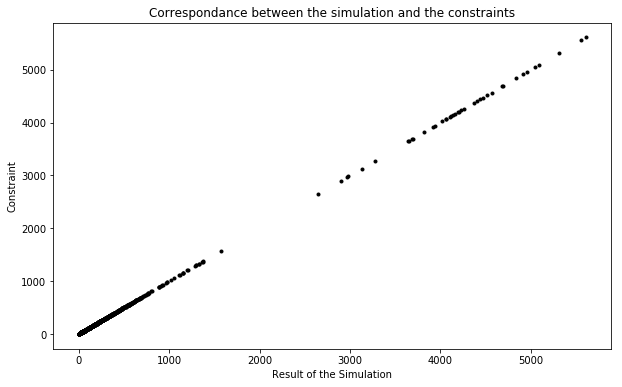

In [13]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,63)].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,63)].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Iterative Proportional Fitting #3
Two dimensional on age-sex-ethnicity and employment as (employed + self-employed), not employed. 
Perfect fit on weights. As it's not clear whether dividing employed and self-employed offers much, I'll move forwards with this.

In [14]:
ind_cat = inds[['sex_age_eth','employ']].copy()
# Recode employ to combine Employed and SelfEmployed
ind_cat['employ2'] = ind_cat['employ'].apply(lambda x: 'Employ2' if x in ['Employed','SelfEmployed'] else 'NotEmployed')

# Make combined Employed and Self-Employed marginal totals
cons['Employ2'] = cons[['Employed','SelfEmployed']].sum(axis=1)

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    employ = cons.iloc[i,[70,63]]
    
    aggregates = [sex_age_eth,employ]
    dimensions = [['sex_age_eth'],['employ2']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [15]:
# Overal marginal distribution of individuals by constraints
ind_agg = ind_catr.sum(axis=0)
# Manually add employed + self-employed value
ind_agg = ind_agg.append(pd.Series([3565],index=['Employ2']))
# marginal distribution of individuals by zone
ind_agg_zone = cons.drop('GEO_CODE',axis=1).apply(lambda x: 1.0*ind_agg, axis=1)
# Add employ2 to ind_catr
ind_catr['Employ2'] = ind_catr[['Employed','SelfEmployed']].sum(axis=1)

ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,60)+[69,62]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[69,62]].ravel())[0,1]

1.0

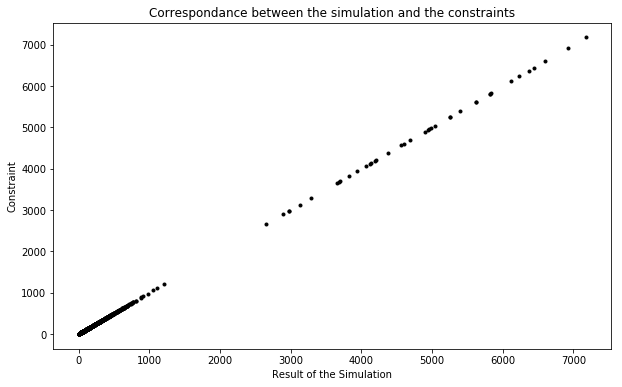

In [16]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,60)+[69,62]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[69,62]].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Iterative Proportional Fitting #4
Two dimensional on age-sex-ethnicity and travel to work. NB travel to work responses basically proxy employment anyway.
Fit is near perfect, and contains important info on commute mode.

This is the fitting we will use.

In [17]:
# Inapplicable captures people that aren't employed
# Home captures people that work at or from home
# Taken together people responding to worktrav could be thought of a self-identified 'commuters' of one sort or another.
pd.crosstab(ind_cat['employ2'],inds['worktrav'])

worktrav,Car,Cycle,Home,Public,Walk,inapplicable
employ2,,,,,,
Employ2,1110,145,231,1579,300,204
NotEmployed,0,0,0,0,0,2516


In [18]:
cons.iloc[:,[64,65,66,67,68,69]]

,Car,Public,Cycle,Walk,Home,inapplicable
0,1539,3788,185,348,469,4054
1,1200,3785,145,291,345,3862
2,2243,3234,197,446,537,3485
3,2228,1714,50,212,515,2536
4,2652,1614,55,225,481,2842
5,1523,3257,201,520,424,3757
6,1602,4906,232,428,471,3741
7,2318,2158,125,353,473,2724
8,2413,1877,87,274,403,2873
9,1395,4545,283,415,557,3669


In [19]:
ind_cat = inds[['sex_age_eth','worktrav']].copy()

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    worktrav =  cons.iloc[i,[64,65,66,67,68,69]]
    
    aggregates = [sex_age_eth,worktrav]
    dimensions = [['sex_age_eth'],['worktrav']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [20]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,60)+[63,64,65,66,67,68]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[63,64,65,66,67,68]].ravel())[0,1]

0.99999999999999978

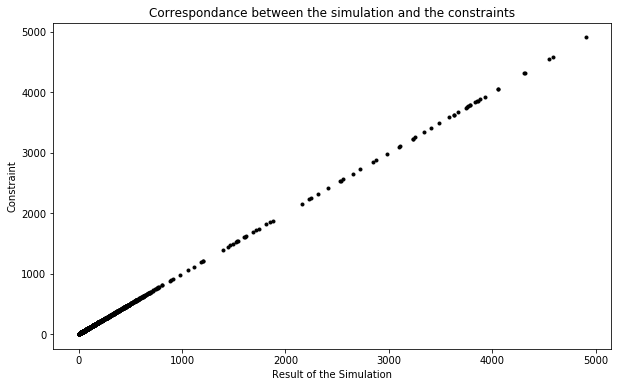

In [21]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,60)+[63,64,65,66,67,68]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[63,64,65,66,67,68]].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Iterative Proportional Fitting #5
Three dimensional on sex-age-ethnicity, employment (2 category) and commute mode. Fit is not perfect, but is nonetheless very high. However, commute mode and employment presumably doing the same thing as?

In [41]:
ind_cat = inds[['sex_age_eth','employ','worktrav']].copy()
# Recode employ to combine Employed and SelfEmployed
ind_cat['employ2'] = ind_cat['employ'].apply(lambda x: 'Employ2' if x in ['Employed','SelfEmployed'] else 'NotEmployed')

# Make combined Employed and Self-Employed marginal totals
cons['Employ2'] = cons[['Employed','SelfEmployed']].sum(axis=1)

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    employ = cons.iloc[i,[70,63]]
    worktrav =  cons.iloc[i,[64,65,66,67,68,69]]
    
    aggregates = [sex_age_eth,worktrav,employ]
    dimensions = [['sex_age_eth'],['worktrav'],['employ2']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [44]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,60)+[63,64,65,66,67,68]+[69,62]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[63,64,65,66,67,68]+[69,62]].ravel())[0,1]

0.99907993361462277

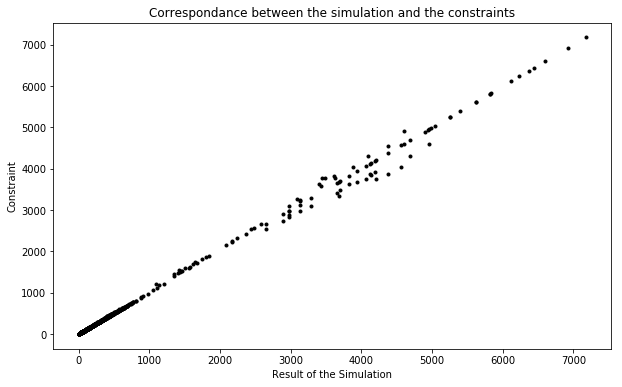

In [45]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,60)+[69,62]+[63,64,65,66,67,68]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[69,62]+[63,64,65,66,67,68]].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Integerisation and Expansion
Using 3D sex-age-eth, employment and worktrav. 

In [22]:
# Truncate, replicate, sample 'TRS' integerisation approach.
def int_trs(weights):
    # convert to a vector if required
    xv = np.array(weights).ravel()
    # truncate - just get the integer part of the weight
    xint = np.floor(xv)
    # Get the decimal bit of the weight
    r = xv - xint
    # Work out the deficit population
    frac_sum = round(r.sum())
    # Sample based upon the deficit bit
    xs = np.random.choice(len(xv),int(frac_sum),True,r/r.sum())
    # Get the result of the deficit part
    topup = np.bincount(xs,minlength=len(xv))
    return xint + topup

def int_expand_vector(weights):
    return np.repeat(range(0,len(weights)),weights.astype(int))

In [29]:
indivs = []
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    # Integerise and expand - gives a list of the ind ids for the ward
    ints = int_expand_vector(int_trs(ind_cat['weight_'+ ward]))
    # Select the relevant individuals and cols
    temp = inds.iloc[ints][['pidp','sex','age_6cat','eth_5cat','employ','worktrav','caruse','cycleuse','f_workdis']]
    temp['ward'] = ward
    indivs.append(temp)
ints_df = pd.concat(indivs)
ints_df.reset_index(inplace=True)
ints_df.head()

,index,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,f_workdis,ward
0,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590
1,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590
2,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590
3,1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,3,E05000590
4,1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,3,E05000590


## Basic Checks
Overall, simulated vs. observed differences are relatively small on constraints, suggesting a decent model.

In [30]:
# sex
# We would expect the constraint variables to be pretty much exact.
# Looks good, slight variation is due to the integerisation process.
print "simulation male", ints_df['sex'].value_counts(normalize=True)['m']
print "observed male", cons[cons.columns[cons.columns.str.contains(r'[m][0-9]')]].sum(axis=1).sum()/float(cons[['Employ2','NotEmployed']].sum(axis=1).sum())

simulation male 0.503178376567
observed male 0.502413890605


In [31]:
# sex by ward - differences are all less than 5% difference.
male_cons = (cons[cons.columns[cons.columns.str.contains(r'[m][0-9]')]].sum(axis=1)/cons[['Employ2','NotEmployed']].sum(axis=1)).to_frame()
male_cons.rename(columns={0:'obs_male'},inplace=True)
male_inds = pd.melt(ints_df.groupby('ward')['sex'].value_counts(normalize=True).to_frame()).iloc[range(0,39,2)].reset_index(drop=True)
male_inds.rename(columns={'value':'sim_male'},inplace=True)
sex_compare = male_inds.merge(male_cons.merge(cons['GEO_CODE'].to_frame(),left_index=True,right_index=True),left_index=True,right_index=True)
sex_compare['diff'] = abs(sex_compare['sim_male']-sex_compare['obs_male'])
sex_compare

,variable,sim_male,obs_male,GEO_CODE,diff
0,sex,0.537417,0.532987,E05000590,0.004430
1,sex,0.505713,0.504778,E05000591,0.000935
2,sex,0.504043,0.499901,E05000592,0.004141
3,sex,0.515507,0.485320,E05000593,0.030186
4,sex,0.515822,0.487610,E05000594,0.028212
5,sex,0.520863,0.519314,E05000595,0.001549
6,sex,0.526538,0.522320,E05000596,0.004218
7,sex,0.519200,0.476751,E05000597,0.042449
8,sex,0.519995,0.476221,E05000598,0.043774
9,sex,0.538936,0.538384,E05000599,0.000552


In [32]:
# age - looks to be in the right ballpark overall
print "Simulated age counts"
print ints_df['age_6cat'].value_counts(normalize=True).sort_index()


ages = ['16_24','25_34','35_44','45_54','55_64','65_74']
age_df = [cons['GEO_CODE']]
for age in ages:
    age_df.append(pd.Series(cons[cons.columns[cons.columns.str.contains(r'[m,f]' + age)]].sum(axis=1),name=age))

age_df = pd.concat(age_df,axis=1)
age_df['total'] = age_df[age_df.columns[1:]].sum(axis=1)
print ""
print "Observed age counts"
print age_df[age_df.columns[1:-1]].sum(axis=0)/age_df[age_df.columns[1:-1]].sum(axis=0).sum()

Simulated age counts
16-24    0.170774
25-34    0.266696
35-44    0.216538
45-54    0.165056
55-64    0.110170
65-74    0.070767
Name: age_6cat, dtype: float64

Observed age counts
16_24    0.171690
25_34    0.265350
35_44    0.216543
45_54    0.165783
55_64    0.110400
65_74    0.070233
dtype: float64


In [33]:
# age by ward - percentage errors are small, and less than 1% in all cases.
age_inds = ints_df.groupby('ward')['age_6cat'].value_counts(normalize=True).sort_index().unstack()
age_df = age_df.merge(age_inds,left_on = 'GEO_CODE',right_index=True)
cols = []
for age in ages:
    cols.append('per_err_' + age)
    age_df['per_err_' + age] = age_df.apply(lambda x: abs((x[age]/float(x['total']) - x[age.replace('_','-')])*100.0) , axis=1)

age_df[cols]

,per_err_16_24,per_err_25_34,per_err_35_44,per_err_45_54,per_err_55_64,per_err_65_74
0,0.240778,0.269672,0.288934,0.288934,0.173360,0.144467
1,0.062318,0.176568,0.186955,0.186955,0.166182,0.280432
2,0.059160,0.088740,0.059160,0.216920,0.019720,0.167620
3,0.289456,0.055134,0.441075,0.468642,0.523777,0.151620
4,0.444783,0.050832,0.025416,0.165205,0.101665,0.101665
5,0.010328,0.599050,0.113613,0.402809,0.092956,0.020657
6,0.096661,0.123023,0.000000,0.008787,0.333919,0.351494
7,0.122684,0.073611,0.662495,0.085879,0.588885,0.208563
8,0.025230,0.428914,0.075691,0.025230,0.126151,0.327993
9,0.211708,0.294551,0.303756,0.064433,0.138071,0.000000


In [34]:
# ethnicity - looks to be in the right ballpark overall
print "Simulated Ethnicity counts"
print ints_df['eth_5cat'].value_counts(normalize=True).sort_index()

eths = ['Asian','Black','Mixed','Other','White']
eth_df = [cons['GEO_CODE']]
for eth in eths:
    eth_df.append(pd.Series(cons[cons.columns[cons.columns.str.contains(eth)]].sum(axis=1),name=eth))

eth_df = pd.concat(eth_df,axis=1)
eth_df['total'] = eth_df[eth_df.columns[1:]].sum(axis=1)
print ""
print "Observed Ethnicity counts"
print eth_df[eth_df.columns[1:-1]].sum(axis=0)/eth_df[eth_df.columns[1:-1]].sum(axis=0).sum()

Simulated Ethnicity counts
Asian    0.208678
Black    0.165438
Mixed    0.035978
Other    0.041052
White    0.548854
Name: eth_5cat, dtype: float64

Observed Ethnicity counts
Asian    0.208726
Black    0.165490
Mixed    0.036360
Other    0.040659
White    0.548765
dtype: float64


In [56]:
# ethnicity by ward. All errors less than 0.55%
eth_inds = ints_df.groupby('ward')['eth_5cat'].value_counts(normalize=True).sort_index().unstack()
eth_df = eth_df.merge(eth_inds,left_on = 'GEO_CODE',right_index=True)

cols = []
for eth in eths:
    cols.append('per_err_' + eth)
    eth_df['per_err_' + eth] = eth_df.apply(lambda x: abs((x[eth  +"_x"]/float(x['total']) - x[eth  +"_y"])*100.0) , axis=1)

eth_df[cols]

,per_err_Asian,per_err_Black,per_err_Mixed,per_err_Other,per_err_White
0,0.125205,0.125205,0.086680,0.009631,0.096311
1,0.020773,0.072705,0.114250,0.207727,0.000000
2,0.266220,0.078880,0.177480,0.009860,0.000000
3,0.344590,0.275672,0.192970,0.055134,0.206754
4,0.393951,0.432075,0.152497,0.190621,0.000000
5,0.000000,0.216897,0.030985,0.092956,0.154927
6,0.175747,0.166960,0.193322,0.035149,0.166960
7,0.245369,0.233100,0.392590,0.208563,0.294442
8,0.378453,0.151381,0.088306,0.126151,0.315378
9,0.147275,0.202504,0.110457,0.101252,0.156480


In [35]:
# Mode of travel to work. - looks decent.
print "Simulated work travel mode counts"
print ints_df['worktrav'].value_counts(normalize=True).sort_index()

modes = ['Car','Cycle','Home','Public','Walk','inapplicable']
trav_df = [cons['GEO_CODE']]
for mode in modes:
    trav_df.append(pd.Series(cons[cons.columns[cons.columns.str.contains(mode)]].sum(axis=1),name=mode))

trav_df = pd.concat(trav_df,axis=1)
trav_df['total'] = trav_df[trav_df.columns[1:]].sum(axis=1)
print ""
print "Observed work travel mode counts"
print trav_df[trav_df.columns[1:-1]].sum(axis=0)/trav_df[trav_df.columns[1:-1]].sum(axis=0).sum()

Simulated work travel mode counts
Car             0.190483
Cycle           0.016960
Home            0.048278
Public          0.335583
Walk            0.039062
inapplicable    0.369634
Name: worktrav, dtype: float64

Observed work travel mode counts
Car             0.190399
Cycle           0.017311
Home            0.048136
Public          0.335431
Walk            0.039272
inapplicable    0.369451
dtype: float64


In [36]:
# mode of travel to work by ward. All errors less than 1%
trav_inds = ints_df.groupby('ward')['worktrav'].value_counts(normalize=True).sort_index().unstack()
trav_df = trav_df.merge(trav_inds,left_on = 'GEO_CODE',right_index=True)

cols = []
for mode in modes:
    cols.append('per_err_' + mode)
    trav_df['per_err_' + mode] = trav_df.apply(lambda x: abs((x[mode  +"_x"]/float(x['total']) - x[mode  +"_y"])*100.0) , axis=1)

trav_df[cols]

,per_err_Car,per_err_Cycle,per_err_Home,per_err_Public,per_err_Walk,per_err_inapplicable
0,0.086680,0.028893,0.048156,0.038525,0.096311,0.067418
1,0.062318,0.155796,0.342750,0.020773,0.093477,0.135023
2,0.285940,0.118320,0.078880,0.118320,0.059160,0.542299
3,0.234321,0.013784,0.013784,0.027567,0.110269,0.399724
4,0.101665,0.139789,0.038124,0.050832,0.190621,0.343119
5,0.082628,0.113613,0.123941,0.041314,0.175584,0.185912
6,0.237258,0.008787,0.026362,0.184534,0.272408,0.202109
7,0.098147,0.036805,0.269906,0.049074,0.110416,0.245369
8,0.037845,0.088306,0.012615,0.340608,0.037845,0.340608
9,0.340574,0.064433,0.018409,0.147275,0.193299,0.211708


In [37]:
# The current model underpredicts not employed by c.6% to the benefit of employed.
# We don't specifically constrain on employed as I thought this info was already in the mode data...
print "Simulation employment"
print ints_df['employ'].value_counts(normalize=True)

emps = ['Employed','NotEmployed','SelfEmployed']
emp_df = [cons['GEO_CODE']]
for emp in emps:
    emp_df.append(pd.Series(cons[cons.columns[cons.columns.str.match(emp)]].sum(axis=1),name=emp))

emp_df = pd.concat(emp_df,axis=1)
emp_df['total'] = emp_df[emp_df.columns[1:]].sum(axis=1)
print ""
print "Observed Employment counts"
print emp_df[emp_df.columns[1:-1]].sum(axis=0)/emp_df[emp_df.columns[1:-1]].sum(axis=0).sum()

Simulation employment
Employed        0.543424
NotEmployed     0.337929
SelfEmployed    0.118647
Name: employ, dtype: float64

Observed Employment counts
Employed        0.477929
NotEmployed     0.398025
SelfEmployed    0.124046
dtype: float64


In [38]:
# Access to a car or van comes in a roughly 50-50
ints_df['caruse'].value_counts(normalize=True)

Car      0.504126
NoCar    0.495874
Name: caruse, dtype: float64

In [39]:
# Car access by ward. Clear variation in predicted access to car by ward. High = 62.3% low = 44.0%. An 18% difference.
ints_df.groupby('ward')['caruse'].value_counts(normalize=True).sort_index()

ward       caruse
E05000590  Car       0.450640
           NoCar     0.549360
E05000591  Car       0.440174
           NoCar     0.559826
E05000592  Car       0.520016
           NoCar     0.479984
E05000593  Car       0.623432
           NoCar     0.376568
E05000594  Car       0.609989
           NoCar     0.390011
E05000595  Car       0.472423
           NoCar     0.527577
E05000596  Car       0.468893
           NoCar     0.531107
E05000597  Car       0.575880
           NoCar     0.424120
E05000598  Car       0.598966
           NoCar     0.401034
E05000599  Car       0.469993
           NoCar     0.530007
E05000600  Car       0.481493
           NoCar     0.518507
E05000601  Car       0.463800
           NoCar     0.536200
E05000602  Car       0.583507
           NoCar     0.416493
E05000603  Car       0.476127
           NoCar     0.523873
E05000604  Car       0.448550
           NoCar     0.551450
E05000605  Car       0.482846
           NoCar     0.517154
E05000606  Car       0

## Predicting bicycle access
We have a slight issue with bicycle access, as the ethnic boost part of the survey wasn't asked about travel behaviours. However, we really need those people to have enough people from ethnic minority populations to create a reasonable synthetic population. This means that 1/3 of the synthetic population has missing on bicycle access.

Therefore, we'll try to model the conditional probability of having bicycle access using the complete case data, and then randomly assign bicycle acccess based on those probabilities to the people who are missing.

In [40]:
# There is a lot of missing on bike use because the ethnic boost don't get asked the question.
ints_df['cycleuse'].value_counts(normalize=True)

missing    0.357580
NoBike     0.343773
Bike       0.298647
Name: cycleuse, dtype: float64

In [41]:
cycle = inds[inds['cycleuse'] != 'missing'] # dataset of 3,933 people.

In [43]:
# cycling is a binary outcome, so we'll use a logistic regression.
from statsmodels.discrete.discrete_model import Logit

# recode outcome (cycling) to binary
cycle['cycle'] = cycle['cycleuse'].apply(lambda x: 1 if x == 'Bike' else 0)

C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [44]:
# Much more likely to have access to a bicycle if male compared to female (OR: 1.92 - almost twice as likely.)
res = Logit.from_formula('cycle~sex',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.668472
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3933
Model:                          Logit   Df Residuals:                     3931
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Oct 2018   Pseudo R-squ.:                 0.01946
Time:                        12:46:26   Log-Likelihood:                -2629.1
converged:                       True   LL-Null:                       -2681.3
                                        LLR p-value:                 1.700e-24
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6014      0.044    -13.560      0.000      -0.688      -0.514
sex[T.m]       0.6669      0.066     10.160      0.000       0.538       0.796
==============================================================================
"""

In [45]:
# Much more likely to have access to a bicycle if younger
res = Logit.from_formula('cycle~age_6cat',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.672757
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3933
Model:                          Logit   Df Residuals:                     3927
Method:                           MLE   Df Model:                            5
Date:                Wed, 17 Oct 2018   Pseudo R-squ.:                 0.01317
Time:                        12:46:29   Log-Likelihood:                -2646.0
converged:                       True   LL-Null:                       -2681.3
                                        LLR p-value:                 7.551e-14
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0408      0.079      0.515      0.607      -0.115       0.196
age_6cat[T.25-34]    -0.3093      0.111     -2.779      0.005      -0.527      -0.091
age_6cat[T.35-44]    -0.3249      0.106     -3.058      0.002      -0.533      -0.117
age_6cat[T.45-54]    -0.1856      0.105     -1.772      0.076      -0.391       0.020
age_6cat[T.55-64]    -0.6729      0.119     -5.651      0.000      -0.906      -0.439
age_6cat[T.65-74]    -0.9501      0.136     -6.969      0.000      -1.217      -0.683
=====================================================================================
"""

In [46]:
# Much more likely to have access to a bicycle if White, Mixed, less likely if Asian, Other
res = Logit.from_formula('cycle~eth_5cat',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.660627
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3933
Model:                          Logit   Df Residuals:                     3928
Method:                           MLE   Df Model:                            4
Date:                Wed, 17 Oct 2018   Pseudo R-squ.:                 0.03097
Time:                        12:46:32   Log-Likelihood:                -2598.2
converged:                       True   LL-Null:                       -2681.3
                                        LLR p-value:                 7.344e-35
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8339      0.064    -13.100      0.000      -0.959      -0.709
eth_5cat[T.Black]     0.2955      0.099      2.996      0.003       0.102       0.489
eth_5cat[T.Mixed]     0.7015      0.147      4.757      0.000       0.412       0.991
eth_5cat[T.Other]     0.2990      0.207      1.446      0.148      -0.106       0.704
eth_5cat[T.White]     0.9671      0.080     12.033      0.000       0.810       1.125
=====================================================================================
"""

In [47]:
cycle['employ2'] = cycle['employ'].apply(lambda x: 'Employed' if x != 'NotEmployed' else 'NotEmployed')

# Much more likely to have access to a bicycle if employed
res = Logit.from_formula('cycle~employ2',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.674190
         Iterations 4


C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3933
Model:                          Logit   Df Residuals:                     3931
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Oct 2018   Pseudo R-squ.:                 0.01107
Time:                        12:46:34   Log-Likelihood:                -2651.6
converged:                       True   LL-Null:                       -2681.3
                                        LLR p-value:                 1.309e-14
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.1061      0.041     -2.583      0.010      -0.187      -0.026
employ2[T.NotEmployed]    -0.5137      0.067     -7.645      0.000      -0.645      -0.382
==========================================================================================
"""

In [48]:
# More likely to have access to a bicycle if also have access to a car
res = Logit.from_formula('cycle~caruse',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.678336
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3933
Model:                          Logit   Df Residuals:                     3931
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Oct 2018   Pseudo R-squ.:                0.004989
Time:                        12:46:37   Log-Likelihood:                -2667.9
converged:                       True   LL-Null:                       -2681.3
                                        LLR p-value:                 2.309e-07
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1512      0.044     -3.472      0.001      -0.237      -0.066
caruse[T.NoCar]    -0.3358      0.065     -5.159      0.000      -0.463      -0.208
===================================================================================
"""

In [49]:
# Fully adjusted model
cycle_model = Logit.from_formula('cycle~sex+age_6cat+eth_5cat+employ2+caruse',data=cycle).fit()
cycle_model.summary()

Optimization terminated successfully.
         Current function value: 0.628186
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3933
Model:                          Logit   Df Residuals:                     3920
Method:                           MLE   Df Model:                           12
Date:                Wed, 17 Oct 2018   Pseudo R-squ.:                 0.07855
Time:                        12:46:38   Log-Likelihood:                -2470.7
converged:                       True   LL-Null:                       -2681.3
                                        LLR p-value:                 1.200e-82
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.3395      0.131     -2.595      0.009      -0.596      -0.083
sex[T.m]                   0.6445      0.070      9.267      0.000       0.508       0.781
age_6cat[T.25-34]         -0.5778      0.123     -4.701      0.000      -0.819      -0.337
age_6cat[T.35-44]         -0.6296      0.120     -5.230      0.000      -0.866      -0.394
age_6cat[T.45-54]         -0.5381      0.119     -4.535      0.000      -0.771      -0.306
age_6cat[T.55-64]         -1.1039      0.131     -8.401      0.000      -1.362      -0.846
age_6cat[T.65-74]         -1.4271      0.152     -9.410      0.000      -1.724      -1.130
eth_5cat[T.Black]          0.3937      0.104      3.801      0.000       0.191       0.597
eth_5cat[T.Mixed]          0.7053      0.152      4.633      0.000       0.407       1.004
eth_5cat[T.Other]          0.3684      0.214      1.723      0.085      -0.051       0.787
eth_5cat[T.White]          1.1078      0.086     12.908      0.000       0.940       1.276
employ2[T.NotEmployed]    -0.2292      0.082     -2.796      0.005      -0.390      -0.069
caruse[T.NoCar]           -0.3089      0.076     -4.060      0.000      -0.458      -0.160
==========================================================================================
"""

In [50]:
# Now get the people with missing on cycleuse
missing = inds[inds['cycleuse'] == 'missing']
# derive employ2 variable
missing['employ2'] = missing['employ'].apply(lambda x: 'Employed' if x != 'NotEmployed' else 'NotEmployed')

# Get the predicted probabilities
missing['prob_cycle'] = cycle_model.predict(missing)
missing.head()

C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,sex_age_eth,f_workdis,employ2,prob_cycle
6,68021781,m,16-24,Black,NotEmployed,inapplicable,NoCar,missing,m16_24Black,-7,NotEmployed,0.540061
50,68912575,m,16-24,White,NotEmployed,inapplicable,NoCar,missing,m16_24White,-7,NotEmployed,0.705721
66,68945891,f,16-24,White,NotEmployed,inapplicable,Car,missing,f16_24White,-7,NotEmployed,0.631605
124,69833965,m,65-74,White,NotEmployed,inapplicable,NoCar,missing,m65_74White,-7,NotEmployed,0.365303
126,69833977,m,25-34,White,NotEmployed,inapplicable,NoCar,missing,m25_34White,-7,NotEmployed,0.573687


In [51]:
# Now, for each missing in the synthetic data, find the predicted probability of that person and randomly allocate.
updates = []
for idx, row in ints_df.iterrows():
    if row['cycleuse'] == 'missing':
        #Get pidp
        pidp = row['pidp']
        # get predicted probability of cycle access from missing table
        prob = missing.loc[missing['pidp']==pidp,'prob_cycle'].values[0]
        # get random number
        rn = np.random.rand()
        update = "Bike" if rn < prob else "NoBike"
        updates.append([idx,update])
# update values
ints_df.iloc[np.array(updates)[:,0].astype(int),8] = np.array(updates)[:,1]

In [52]:
# In line with the 43% of people in the UK who have access to a bike - National Travel Survey
ints_df['cycleuse'].value_counts(normalize=True)

NoBike    0.53491
Bike      0.46509
Name: cycleuse, dtype: float64

In [74]:
# cycle access by ward - low = 42.6% high = 50.2% - a 7% difference.
ints_df.groupby('ward')['cycleuse'].value_counts(normalize=True).sort_index()

ward       cycleuse
E05000590  Bike        0.462679
           NoBike      0.537321
E05000591  Bike        0.438513
           NoBike      0.561487
E05000592  Bike        0.470420
           NoBike      0.529580
E05000593  Bike        0.501999
           NoBike      0.498001
E05000594  Bike        0.496124
           NoBike      0.503876
E05000595  Bike        0.431006
           NoBike      0.568994
E05000596  Bike        0.451933
           NoBike      0.548067
E05000597  Bike        0.488652
           NoBike      0.511348
E05000598  Bike        0.495648
           NoBike      0.504352
E05000599  Bike        0.467047
           NoBike      0.532953
E05000600  Bike        0.450473
           NoBike      0.549527
E05000601  Bike        0.464668
           NoBike      0.535332
E05000602  Bike        0.480852
           NoBike      0.519148
E05000603  Bike        0.426088
           NoBike      0.573912
E05000604  Bike        0.430705
           NoBike      0.569295
E05000605  Bike     

In [53]:
# Save the synthetic dataset
ints_df.to_csv('../Data/Synthetic_WF.csv')